## SEC Filings Explained

| Form | Description | Frequency | Filed By | Focus |
|---|---|---|---|---|
| 10-K | Annual Report | Annual | Public Companies | Comprehensive overview of financial condition, business operations, and future prospects |
| 10-Q | Quarterly Report | Quarterly | Public Companies | Update on financial performance |
| 8-K | Current Event Report | As needed | Public Companies | Material events affecting shareholders |
| 20-F | Annual Report (Foreign Issuer) | Annual | Non-Canadian Foreign Private Issuers | Similar to 10-K |
| 40-F | Ongoing Report (Canadian Issuer) | As needed | Certain Canadian Companies | Registration and ongoing disclosures |
| 10-K/A | Amendment to 10-K | As needed | Public Companies | Correction or update to previously filed 10-K |
| 10-Q/A | Amendment to 10-Q | As needed | Public Companies | Correction or update to previously filed 10-Q |
| 6-K | Foreign Issuer Cover Sheet | As needed | Foreign Private Issuers (not required to file 10-K/Q) | Publicly available information from home country |


In [1]:
# Load Packages
import pandas as pd
import numpy as np
import tidyxbrl
import plotly.express as px
import plotly.graph_objects as go

from src.tidyxbrl.xbrl_apikey import *
from src.tidyxbrl.xbrl_query import *
from src.tidyxbrl.xbrl_parse import *
from src.tidyxbrl.edgar_query import *
from src.tidyxbrl.edgar_cik import *
from src.tidyxbrl.edgar_frames import *

pd.set_option("display.max_colwidth", None)

In [2]:
%%capture
# Load Company Identifiers (CIK) for relevant companies
companylist = [
    "avison young",
    "brookfield asset management",
    "jones lang lasalle inc",
    "cbre group, inc.",
    "cushman & wakefield plc",
    "newmark group, inc",
    "colliers international group inc.",
    "brookfield asset management",
    "american tower",
    "prologis",
    "crown castle",
    "weyerhaeuser",
    "equinix",
    "equity residential",
    "public storage",
    "alexandria real estate",
    "avalonbay communities",
    "digital realty",
    "boston properties",
    "segro",
    "vici properties",
    "ventas",
    "welltower",
    "realty income corporation",
    "annaly capital management",
    "essex property trust",
    "simon property group",
]

company_cik_list = pd.DataFrame()
for company in companylist:
    company_cik_list = pd.concat(
        [company_cik_list, edgar_cik(company, comprehensive=False)]
    )

company_cik_list = company_cik_list.reset_index(drop=True).drop_duplicates()

print(company_cik_list.head(10).to_string())

In [3]:
%%capture
# Load company data

### Series

submissions_raw = pd.DataFrame()
company_facts_raw = pd.DataFrame()

for index, desiredcorp in company_cik_list.iterrows():
    print(desiredcorp)
    try:
        submissions = edgar_query(
            desiredcorp.cik_str, query_type="submissions", parse_pandas=True
        )
    except:
        submissions = pd.DataFrame()
    try:
        companyfacts = edgar_query(
            desiredcorp.cik_str, query_type="companyfacts", parse_pandas=True
        )
    except:
        companyfacts = pd.DataFrame()
    submissions_raw = pd.concat([submissions_raw, submissions])
    company_facts_raw = pd.concat([company_facts_raw, companyfacts])

submissions = pd.merge(
    company_cik_list, submissions_raw, how="left", left_on=["cik"], right_on=["cik"]
)
company_facts = pd.merge(
    company_cik_list,
    company_facts_raw,
    how="left",
    left_on=["cik"],
    right_on=["cik"],
)


### Parallel (Not Reccomended)

# import concurrent.futures

# # Define a function to process each desiredcorp
# def process_desiredcorp(desiredcorp):
#     try:
#         submissions = edgar_query(desiredcorp.cik_str, query_type="submissions", parse_pandas=True)
#     except:
#         submissions = pd.DataFrame()
#     try:
#         companyfacts = edgar_query(desiredcorp.cik_str, query_type="companyfacts", parse_pandas=True)
#     except:
#         companyfacts = pd.DataFrame()
#     return submissions, companyfacts

# # Create an empty list to store the results
# results = []

# # Create a ProcessPoolExecutor
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     # Submit each desiredcorp to the executor
#     futures = [executor.submit(process_desiredcorp, desiredcorp) for index, desiredcorp in company_cik_list.iterrows()]

#     # Retrieve the results as they become available
#     for future in concurrent.futures.as_completed(futures):
#         results.append(future.result())

# # Concatenate the results
# submissions_raw = pd.concat([result[0] for result in results])
# company_facts_raw = pd.concat([result[1] for result in results])

# # Merge the dataframes
# submissions = pd.merge(company_cik_list, submissions_raw, how="left", left_on=["cik"], right_on=["cik"])
# company_facts = pd.merge(company_cik_list, company_facts_raw, how="left", left_on=["cik"], right_on=["cik"])

In [4]:
%%capture
# Show numbr of occurances for each category
print(
    company_facts.query("variable.notna()")
    .groupby(["variable"])
    .count()
    .sort_values(by=["cik"], ascending=False)
    .query("cik >= cik.max()/2 & variable.str.contains('units.USD')")
    .to_string()
)

In [5]:
# Format the data

plotting_values = {
    "facts.us-gaap.InterestExpense.units.USD": "flow",
    "facts.us-gaap.NetIncomeLoss.units.USD": "flow",
    "facts.us-gaap.Assets.units.USD": "static",
    "facts.us-gaap.Liabilities.units.USD": "static",
}


def edgar_data_clean(company_facts, plotting_values):

    raw_plotting_data = (
        pd.concat(
            [
                row.value.reset_index(drop=True).assign(
                    company=row.company, variable=row.variable
                )
                for _, row in company_facts[
                    company_facts.variable.isin(list(plotting_values.keys()))
                ].iterrows()
            ],
            ignore_index=True,
        )
        .reset_index(drop=True)
        .query("fy != 0")
        .assign(
            filed=lambda x: pd.to_datetime(x.filed),
            fp=lambda x: np.where(x.fp.isin(["FY", ""]), "Q4", x.fp),
            date=lambda x: pd.to_datetime(
                x["fy"].astype(str) + "-" + x["fp"].astype(str)
            )
            + pd.DateOffset(months=3),
            start=lambda x: pd.to_datetime(x.start),
            end=lambda x: pd.to_datetime(x.end),
            frame=lambda x: x.frame.fillna("months_ended"),
            frame_date=lambda x: pd.to_datetime(
                x.frame.str.replace("CY", ""), errors="coerce"
            ),
        )
        .query("frame_date.isna() | frame_date==date")
    )

    raw_plotting_data_filtered = (
        raw_plotting_data.query(
            "form.isin(['10-K', '20-F', '10-KA', '6-K', '10-Q', '10-QA'])"
        )
        .groupby(["date", "company", "variable"], group_keys=False)
        .apply(lambda x: x.loc[x.end.idxmax()])
        .reset_index(drop=True)
        .assign(start=lambda x: np.where(x.start.isna(), x.end, x.start))
        .query("start.dt.year == end.dt.year")
        .groupby(["date", "company", "variable"], group_keys=False)
        .apply(lambda x: x.loc[x.start.idxmax()])
        .reset_index(drop=True)
        .assign(category=lambda x: x.variable.map(plotting_values),
                quarter=lambda x: x.date.dt.quarter)
        .assign(
            val=lambda x: np.where(
                (x.form.isin(["10-K", "20-F", "10-KA", "6-K"]))
                & (x.category == "flow"),
                x.val / 4,
                x.val,
            )
        )
    )

    plotting_data = (
        raw_plotting_data_filtered.pivot(
            index=["date","quarter" ,"accn", "fy", "fp", "form", "filed", "frame", "company"],
            columns="variable",
            values="val",
        )
        .reset_index()
        .sort_values(["form", "company", "date", "frame", "fy"])
        .reset_index(drop=True)
    )

    for columnholder in list(
        {k: v for k, v in plotting_values.items() if v == "flow"}.keys()
    ):

        plotting_data[columnholder] = plotting_data.groupby(
            ["form", "company", "date"], group_keys=False
        )[columnholder].ffill()

        mask = (
            (plotting_data.frame == "months_ended")
            & (plotting_data.quarter != 1)
            & (~plotting_data.form.isin(["10-K", "20-F", "10-KA", "6-K"]))
        )

        plotting_data.loc[mask, columnholder] = (
            plotting_data.loc[mask]
            .groupby(["form", "company", "fy"], group_keys=False)[columnholder]
            .apply(lambda x: (x - x.shift(1)))
        )

    return plotting_data


plotting_data = (
    edgar_data_clean(company_facts, plotting_values)
    .assign(
        interest_percent_income=lambda x: 100
        * (x["facts.us-gaap.InterestExpense.units.USD"])
        / (x["facts.us-gaap.NetIncomeLoss.units.USD"])
    )
    .assign(
        interest_percent_income=lambda x: np.where(
            (x.interest_percent_income > -500)
            & (x.interest_percent_income < 500)
            & (x.interest_percent_income.notna()),
            x.interest_percent_income,
            np.nan,
        )
    )
    .assign(
        interest_asset_fraction=lambda x: 100
        * 4
        * (x["facts.us-gaap.InterestExpense.units.USD"])
        / (x["facts.us-gaap.Assets.units.USD"])
    )
    .sort_values(["company", "date", "fy"])
)

plotting_values_figure = np.unique(
    list(plotting_values.keys())
    + ["interest_percent_income", "interest_asset_fraction"]
)

plotting_data.head(5)

variable,date,accn,fy,fp,form,filed,frame,company,facts.us-gaap.Assets.units.USD,facts.us-gaap.InterestExpense.units.USD,facts.us-gaap.Liabilities.units.USD,facts.us-gaap.NetIncomeLoss.units.USD,quarter,interest_percent_income,interest_asset_fraction
318,2010-07-01,0001104659-10-041919,2010,Q2,10-Q,2010-08-04,CY2010Q2I,"ALEXANDRIA REAL ESTATE EQUITIES, INC.SIC: 6798 - REAL ESTATE INVESTMENT TRUSTS",5.565159e+09,NaN,3.008129e+09,NaN,3,NaN,NaN
319,2010-07-01,0001104659-10-041919,2010,Q2,10-Q,2010-08-04,months_ended,"ALEXANDRIA REAL ESTATE EQUITIES, INC.SIC: 6798 - REAL ESTATE INVESTMENT TRUSTS",NaN,NaN,NaN,NaN,3,NaN,NaN
320,2010-10-01,0001104659-10-057300,2010,Q3,10-Q,2010-11-09,CY2010Q3I,"ALEXANDRIA REAL ESTATE EQUITIES, INC.SIC: 6798 - REAL ESTATE INVESTMENT TRUSTS",5.748625e+09,NaN,2.839850e+09,NaN,4,NaN,NaN
321,2010-10-01,0001104659-10-057300,2010,Q3,10-Q,2010-11-09,months_ended,"ALEXANDRIA REAL ESTATE EQUITIES, INC.SIC: 6798 - REAL ESTATE INVESTMENT TRUSTS",NaN,16111000.0,NaN,NaN,4,NaN,NaN
0,2011-01-01,0001104659-11-011479,2010,Q4,10-K,2011-03-01,months_ended,"ALEXANDRIA REAL ESTATE EQUITIES, INC.SIC: 6798 - REAL ESTATE INVESTMENT TRUSTS",5.905861e+09,17410500.0,2.919533e+09,NaN,1,NaN,1.179201


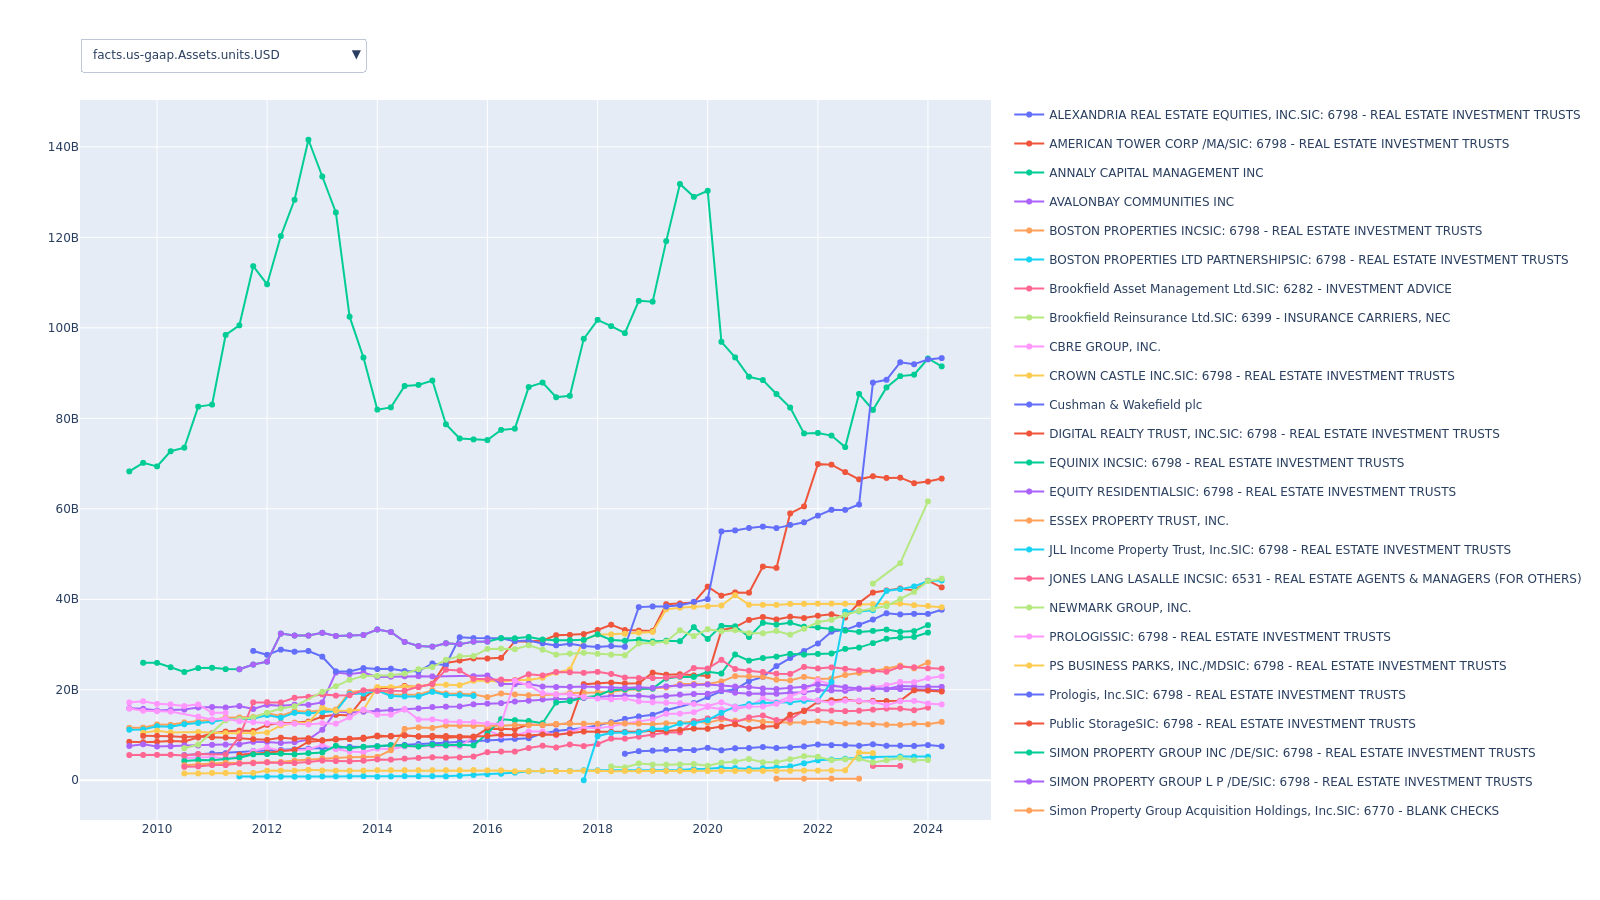

In [11]:
# Data Plotting

# Define the y-values
y_values = plotting_values_figure  # replace with your y-value column names
title_list = plotting_data["company"].unique().tolist()

# Define the colormap
color_sequence = px.colors.qualitative.Plotly

# Create the base figure
fig = go.Figure()

# Add traces for each y-value and company
for y_value in y_values:
    for i, company in enumerate(title_list):
        company_data = plotting_data[
            (plotting_data["company"] == company) & (plotting_data[y_value].notna())
        ]
        fig.add_trace(
            go.Scatter(
                x=company_data["date"],
                y=company_data[y_value],
                mode="lines+markers",
                name=company,
                legendgroup=company,
                line=dict(color=color_sequence[i % len(color_sequence)]),
                visible=(
                    y_value == y_values[0]
                ),  # only the traces for the first y-value are visible initially
            )
        )

# Define the dropdown menu
dropdown_menu = [
    dict(
        args=[
            {"visible": [y_value == y for y in y_values for _ in title_list]}
        ],  # update the 'visible' attribute of the traces
        label=y_value,
        method="restyle",
    )
    for y_value in y_values
]

# Update the layout
fig.update_layout(
    updatemenus=[
        dict(
            buttons=dropdown_menu,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0,
            xanchor="left",
            y=1.1,
            yanchor="top",
        ),
    ],
    autosize=True,
)

# fig.show()

from IPython.display import Image
Image(fig.to_image(format="png", width=1600, height=900, scale=1))